In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

***Show the Image***

In [2]:
def show_image_plt(img_rgb):
    plt.imshow(img_rgb)
    plt.show()

***height (rows), width(cols)***

In [3]:
def resize_to_square(vegi_bgr):
    if vegi_bgr.shape[0] == 256 and vegi_bgr.shape[1] == 256:
        return vegi_bgr
    
    img_size = 256
    height, width = vegi_bgr.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi_bgr, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        resized_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        resized_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        resized_img = r_img[0:img_size, 0:img_size]

    if(resized_img.shape[0] != img_size or resized_img.shape[1] != img_size):
        resized_img = r_img[0:img_size, 0:img_size]

    return resized_img

https://realpython.com/python-opencv-color-spaces/

Applying the median filter https://theailearner.com/tag/cv2-medianblur/

https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/

https://docs.opencv.org/4.x/de/d62/tutorial_bounding_rotated_ellipses.html

Approach: https://stackoverflow.com/questions/72100376/opencv-how-to-draw-a-rotated-bounding-box-in-python

compute dynamically thresholds: https://stackoverflow.com/questions/24862374/canny-edge-detector-threshold-values-gives-different-result

In [4]:
def draw_contours(bgr_img, object_area):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    _, saturation, _ = cv2.split(hsv)

    blurred_sat = cv2.GaussianBlur(saturation, (3, 3), 0)

    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    std = blurred_sat.std()
    thresh_low = thresh - std
    thresh_high = thresh + std
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation
    #thresh_low = 0.3 * thresh 
    #thresh_high = 2 * thresh
    
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)
    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix
    dilate = cv2.dilate(edges, kernel, iterations=4)
    erode = cv2.erode(dilate, kernel, iterations=4)

    contours, _ = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    
    bgr_img_copy = bgr_img.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(bgr_img_copy, [box], 0, (0, 255, 0), 2)
            
            # Calculate Circularity
            perimeter = cv2.arcLength(contour, True)
            r_circle = perimeter / (2 * np.pi)
            A_circle = r_circle**2 * np.pi
            circularity = area / A_circle
            
            if i > 0:
                # There are more than 2 boxes in the image
                more_than_one_box = True
    
    rgb = cv2.cvtColor(bgr_img_copy, cv2.COLOR_BGR2RGB)
    return rgb, more_than_one_box, box, rect, area, circularity

def get_size_box(box):
    x0 = box[0][0]
    y0 = box[0][1]
    x1 = box[1][0]
    y1 = box[1][1]

    x2 = box[2][0]
    y2 = box[2][1]

    l0_1 = round(((x0 - x1)**2 + (y0 - y1)**2)**0.5, 2)
    l1_2 = round(((x1 - x2)**2 + (y1 - y2)**2)**0.5, 2)

    w = min(l0_1, l1_2)
    h = max(l0_1, l1_2)
    return h, w

def is_box_rotated(box):
    # If the box is not rotated then the top left corner should be the first element in box array
    x0, y0 = box[0][0], box[0][1]
    y1 = box[1][1]
    x3 = box[3][0]
    
    if y0 == y1 and x0 == x3:
        # box is not rotated
        return False
    # BOX IS ROTATED
    return True

def get_color(rgb_segment):
    cropped_vegi_2D = rgb_segment.reshape((-1,3))
    # convert to np.float32
    cropped_vegi_2D = np.float32(cropped_vegi_2D)

    # define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
    ret, label, center = cv2.kmeans(cropped_vegi_2D, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
   
    res = center[label.flatten()]
    res2 = res.reshape((rgb_segment.shape))
    
    #returns center in rgb format
    return center, ret, label

def mask_green(cropped_vegi_seg_rgb, lower_thresh=(30, 175, 25), higher_thresh=(100, 255, 255)):
    ## Convert to HSV
    cropped_vegi_seg_hsv = cv2.cvtColor(cropped_vegi_seg_rgb, cv2.COLOR_RGB2HSV)

    ## Mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(cropped_vegi_seg_hsv, lower_thresh, higher_thresh)
    
    ## Slice the green
    imask = mask>0
    green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    green_rgb[imask] = cropped_vegi_seg_rgb[imask]
    return green_rgb, imask

    #Image as BGR
def segment_img_2(cropped_vegi_bgr):
    #img must be BGR
    gray = cv2.cvtColor(cropped_vegi_bgr, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)
    return thresh

def color_from_segmented_binary(seg_bin, cropped_vegi_bgr):
    imask = seg_bin>0 #False / True array
    segment = np.zeros_like(cropped_vegi_bgr, np.uint8)
    segment[imask] = cropped_vegi_bgr[imask] #BGR

    segment_rgb = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB) #RGB
    return segment_rgb

def count_green_pixels(binary_green_mask):
    #only count True boolean. These are my green pixels
    return binary_green_mask.sum()
    
def sift(img_bgr):
    gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # 256 x 256
    sift = cv2.SIFT_create(65536)
    kp, _ = sift.detectAndCompute(gray_img, None)
    #img = cv2.drawKeypoints(gray_img, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    total = 0
    for key in kp:
        total += key.size
    mean = total / len(kp)
    return len(kp), mean

def crop_roi(img_bgr, box):
    left_point, top_point = np.min(box, axis=0) # left point = x coordiante, top point y coordinate could be from different points ! 
    right_point, bottom_point = np.max(box, axis=0)
   
    #new width and height
    if top_point < 0:
        top_point = 0

    if left_point < 0:
        left_point = 0

    if right_point > 256:
        right_point = 256

    if bottom_point > 256:
        bottom_point = 256

    h_new = bottom_point - top_point #rows
    w_new = right_point - left_point #cols

    new_top_left_point = np.array([left_point, top_point])

    new_crop = img_bgr[new_top_left_point[1]:new_top_left_point[1]+h_new, new_top_left_point[0]:new_top_left_point[0]+w_new]
    return new_crop

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [5]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for fname in os.listdir(f"G:/Meine Ablage/KI_Projekt/Testdaten/{fold}"):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Testdaten/{fold}/{fname}")
paths[0]  

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'G:/Meine Ablage/KI_Projekt/Testdaten/Kartoffel'

For Testdata

In [ ]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for fname in os.listdir(f"G:/Meine Ablage/KI_Projekt/Testdaten/Von_Ilias/{fold}"):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Testdaten/Von_Ilias/{fold}/{fname}")

In [6]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Trainingsdaten/Karotte_Trieb/karotte_trieb_209.jpg']
paths = demo_img

In [7]:
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels",
                                 "green onion pixels", "ratio area", "circularity", 
                                 "keypoints", "mean keypoints", "Label", "Image"])
error_counter = 0
for i, path in enumerate(paths):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[4]
 
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = resize_to_square(vegi_BGR) # BGR

    try:
        ############################# Find Contours in image and draw a bounding box ##################################
        vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = draw_contours(vegi_sq_BGR_original, object_area=500)
        if more_than_one_box:
            box_size = 500
            while more_than_one_box:  # makes sure there is only one bounding box in the image
                box_size += 250
                vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = draw_contours(vegi_sq_BGR_original, box_size)

        ############################# Get pixel size from the bounding box (hight and width) ##################################
        h, w = [int(l) for l in get_size_box(box)]
        
        ############################# Calculate the Ratio Area Feature ##################################
        ratio_area_box = 0
        if h > 0 and w > 0:
            ratio_area_box = area / (h * w)

        ############################# Crop the including area from the bounding box (our ROI) ##################################
        if not is_box_rotated(box):
            #crop img directly
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
            
        else:
            cropped_vegi_BGR = crop_roi(vegi_sq_BGR_original, box) # BGR

        ############################# Do a binary segmentation only with the roi  ##################################
        cropped_segmented_binary_2 = segment_img_2(cropped_vegi_BGR)
        #print("Segmented BINARY From Cop NEW")
        #show_image_plt(cropped_segmented_binary_2)

        ############################# Apply the binary mask on the cropped image  ##################################
        cropped_vegi_segmented_rgb_2 = color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR) # center has rgb format
        #print("Segmented RGB")
        #show_image_plt(cropped_vegi_segmented_rgb_2)

        ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
        num_kps, mean_kps = sift(vegi_sq_BGR_original)

        ############################# Apply a green mask on the image ##################################
        # Seems to be work best
        vegi_only_onion_tribe_rgb, onion_tribe_mask = mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
        #print("ONLY GREEn TRIBE MASK")
        #show_image_plt(vegi_only_onion_tribe_rgb)
        vegi_only_tribe_rgb, tribe_mask = mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
        ############################# Calculates the number of green pixels feature  ##################################
        amount_green_pixels_onion_tribe = count_green_pixels(onion_tribe_mask)
        amount_green_pixels_tribe = count_green_pixels(tribe_mask)
        ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
        center, ret, label = get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
        R, G, B = np.max(center, axis=0)
        
        a = path.split(".")
        b = a[0].split("_")
        img_name = f"{vegi_label}_{b[-1]}"
        vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, vegi_label, img_name]
        
        if i < 3:
            print(vegis_df)
        
    except Exception as e:
        print(f"########## Error: {e}")
        error_counter += 1
    

   Hight  Width   R   G   B  green pixels  green onion pixels  ratio area  \
0    261    178  86  84  54          6193                7660    0.505962   

   circularity  keypoints  mean keypoints          Label              Image  
0     0.268763        254        4.563517  Karotte_Trieb  Karotte_Trieb_209  


The resized image to 256x256 pixels


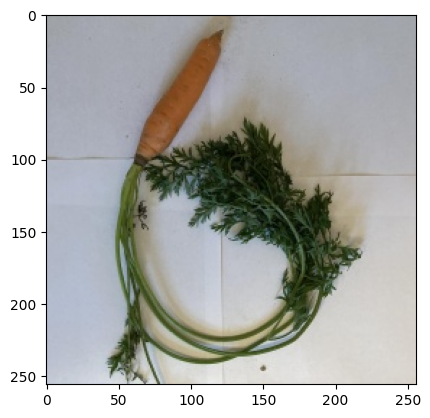

In [8]:
print("The resized image to 256x256 pixels")
show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

Shows the bounding box which was drawed around the founded contours


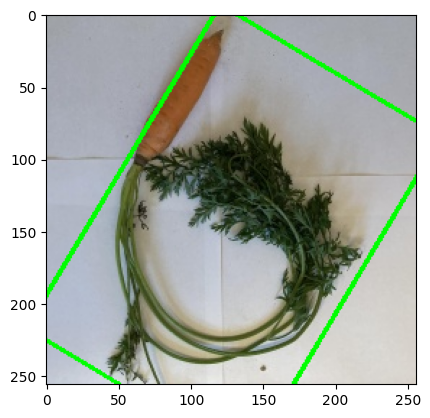

In [9]:
print("Shows the bounding box which was drawed around the founded contours")
show_image_plt(vegi_with_box_rgb)

Segmented Binary Image 


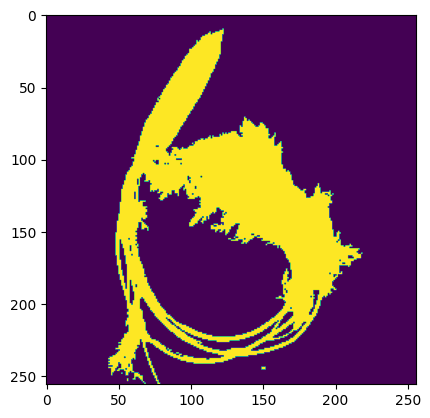

In [10]:
print("Segmented Binary Image ")
show_image_plt(cropped_segmented_binary_2)

Segmented Image after applying the binary mask


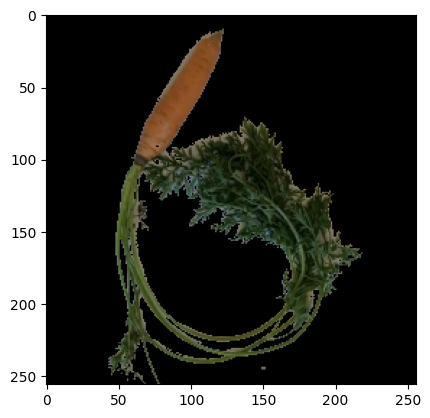

In [11]:
print("Segmented Image after applying the binary mask")
show_image_plt(cropped_vegi_segmented_rgb_2)

Shows the green color mask to get only the green pixels from the image


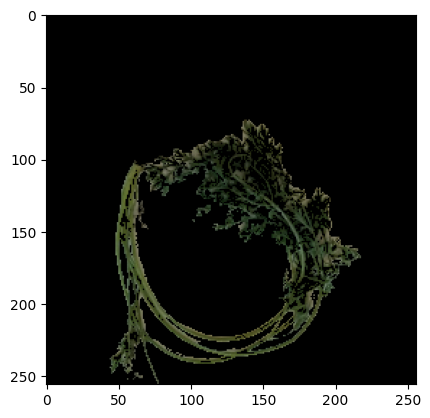

In [12]:
print("Shows the green color mask to get only the green pixels from the image")
show_image_plt(vegi_only_onion_tribe_rgb)

In [13]:
print("Finally the Dataframe with the extracted features from the input image")
print(vegis_df.head(2))

Finally the Dataframe with the extracted features from the input image
   Hight  Width   R   G   B  green pixels  green onion pixels  ratio area  \
0    261    178  86  84  54          6193                7660    0.505962   

   circularity  keypoints  mean keypoints          Label              Image  
0     0.268763        254        4.563517  Karotte_Trieb  Karotte_Trieb_209  


In [ ]:
#vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/.csv")

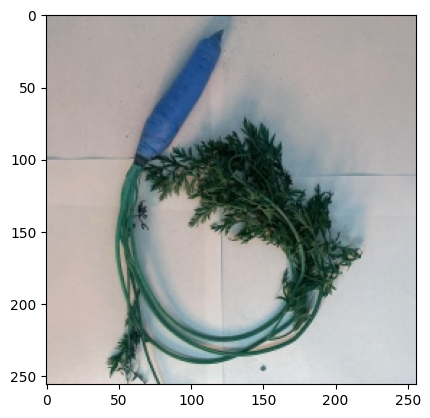

In [ ]:
show_image_plt(cropped_vegi_BGR)

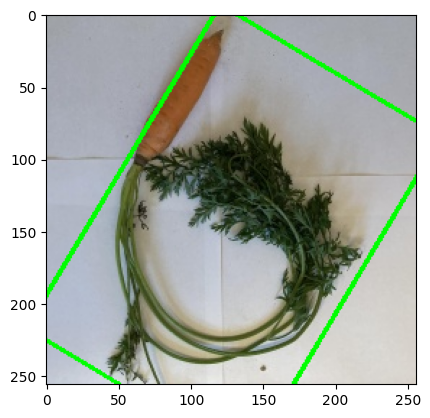

In [14]:

show_image_plt(vegi_with_box_rgb)

In [15]:
print(rect)

((129.86119079589844, 151.27687072753906), (178.8002166748047, 262.0303649902344), 30.815702438354492)


In [16]:
print(box)

[[-14 217]
 [120  -7]
 [273  84]
 [139 309]]


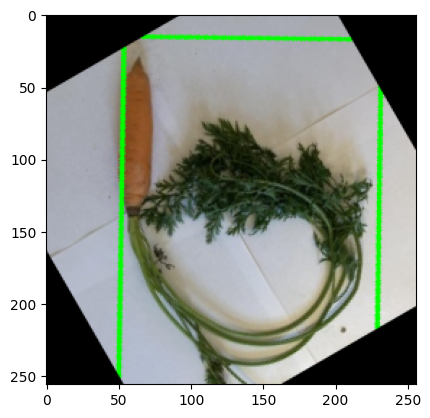

In [29]:
import imutils
r1 = imutils.rotate(vegi_with_box_rgb, 30)
show_image_plt(r1)

In [19]:
import math

In [20]:
v1 = box[1] - box[0]
print("v1: ", v1)

reference_point = np.array([100, box[0][1]])
print(reference_point)
v_horizontal = reference_point - box[0]
print("v_horiz: ", v_horizontal)
assert(v_horizontal[1] == 0)
length_p0_p1 = np.linalg.norm(v1)
scalar_product = np.dot(v1, v_horizontal)
magnitude =  length_p0_p1 * np.linalg.norm(v_horizontal)
angle_cos = round(math.degrees(math.acos(scalar_product / magnitude)), 2)
print(angle_cos)
assert(angle_cos <= 90.0 and angle_cos >= 0.0)  # I think there angle should always between 0 and 90. Because I always take the most left corner

length_p0_p3 = np.linalg.norm(box[0] - box[3])
print("length p0_p1: ", length_p0_p1)
print("length p0_p3: ", length_p0_p3)

# Idea is get the short sides of rectangle, find the middle and draw a parallel line from the middle point to the opposite side
if length_p0_p1 < length_p0_p3:
    # length_p0_p1 is the short one
    pass
else:
    # length_p0_p1 is the long one
    middle_point = np.array([(box[2][0] + box[1][0])/2, (box[2][1] + box[1][1])/2])
    print("Middle_point: ", middle_point)
    # Additional check: If one coordiante is negative then try the oposite side 
    

v1:  [ 134 -224]
[100 217]
v_horiz:  [114   0]
59.11
length p0_p1:  261.02107194630855
length p0_p3:  178.53010950537168
Middle_point:  [196.5  38.5]


In [47]:
# Only if box is rotated - check it with the box_rotated function()
po, p1, p2, p3 = box[0], box[1], box[2], box[3]
print(po, p1, p2, p3)
# Calculate the directions of the vectors, once
u_0_1 = p1 - po
print("Vector u_0_1: ", u_0_1)
u_1_2 = p2 - p1
print("Vector u_1_2: ", u_1_2)
po_moved = False
p1_moved = False
#If po_x not within the image
if po[0] < 0:
    po_moved = True
    # Move po along the direction of u_0_1
    # p0_new = p0 + eps * u_0_1
    eps = (po[0] * (-1)) / u_0_1[0]
    po_y_new = po[1] + eps * u_0_1[1]
    print(f"New po_x= {0} po_y= {po_y_new}")
    p0_y_new = int(po_y_new)
    print(f"Rounded down: po_y_new= {p0_y_new}")

    if p3[1] > 255:
        # If I have the case every edge point is outside the image, then I have to create a complete new bounding box
        pass

if p1[1] < 0:
    p1_moved = True
    # Move p1 along the direction of u_0_1
    eps = (p1[1] * (-1)) / u_0_1[1]
    p1_x_new = p1[0] + eps * u_0_1[0]
    print(f"New p1_x= {p1_x_new} p1_y= {0}")
    p1_x_new = int(p1_x_new)
    print(f"Rounded down: p1_x_new= {p1_x_new}")

    if p2[0] > 255:
        p2_x_new = 255
        # Create complete new P2 by moving p1 along the direction of u_1_2
        eps = (p2_x_new + (p1_x_new * (-1))) / u_1_2[0]
        p2_y_new = 0 + eps * u_1_2[1]  # p1_y_new = 0
        print(f"New p2_x= {p2_x_new} p2_y= {p2_y_new}")
        p2_y_new = int(p2_y_new)
        print(f"Rounded down: p2_y_new= {p2_y_new}")
    elif p2[1] <= 255:
        # Move p2 along the direction of u = p1_new - p1, and just add the components of u to p2
        u_p1_p1_new = (p1_x_new - int(p1[0]), int(p1[1])*(-1))
        print(u_p1_p1_new, type(u_p1_p1_new))
        p2_x_new = u_p1_p1_new[0] + p2[0]
        p2_y_new = u_p1_p1_new[1] + p2[1]
        print(f"New P2 by moving along direction of (p1, p1_new): p2_x_new= {p2_x_new}, p2_y_new= {p2_y_new}")

p3_y_new = 255
eps = (p3_y_new + (p2_y_new * (-1))) / u_0_1[1]
p3_x_new = int(p2_x_new + eps * u_0_1[0])
print(f"New p3_x= {p3_x_new} p3_y= {p3_y_new}")

[-14 217] [120  -7] [273  84] [139 309]
Vector u_0_1:  [ 134 -224]
Vector u_1_2:  [153  91]
New po_x= 0 po_y= 193.59701492537314
Rounded down: po_y_new= 193
New p1_x= 115.8125 p1_y= 0
Rounded down: p1_x_new= 115
New p2_x= 255 p2_y= 83.26797385620915
Rounded down: p2_y_new= 83
New p3_x= 152 p3_y= 255


In [40]:
type(p1_x_new)

int

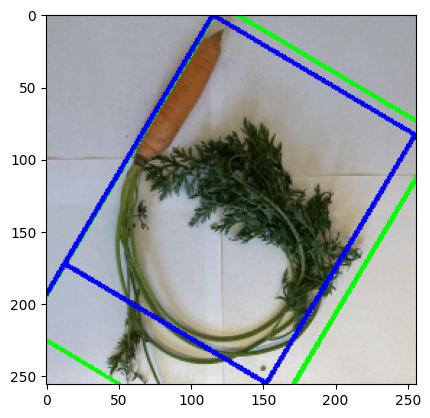

In [60]:
vegi_new_box = vegi_with_box_rgb.copy()

vegi_new = cv2.line(vegi_new_box, (0, p0_y_new), (p1_x_new, 0), (0, 0, 255), 2)
vegi_new = cv2.line(vegi_new, (p1_x_new, 0), (255, p2_y_new), (0, 0, 255), 2)
vegi_new = cv2.line(vegi_new, (255, p2_y_new), (p3_x_new, p3_y_new), (0, 0, 255), 2)
vegi_new = cv2.line(vegi_new, (p3_x_new, p3_y_new), (12, 172), (0, 0, 255), 2)
show_image_plt(vegi_new)

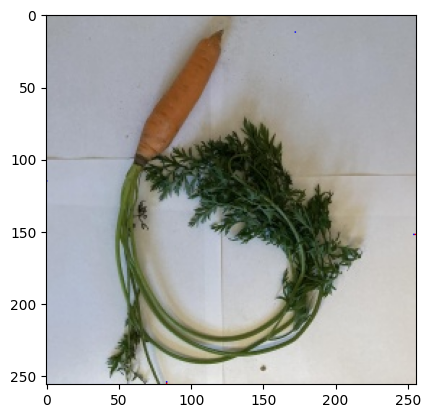

In [120]:
vegi_new_box = vegi_BGR.copy()
vegi_new_box = cv2.cvtColor(vegi_new_box, cv2.COLOR_BGR2RGB)
#vegi_new_box = cv2.line(vegi_new_box, (p1_x_new, 0), (p1_x_new, 0), (0, 0, 255), 1)
#vegi_new_box = cv2.line(vegi_new_box, (255, p2_y_new), (255, p2_y_new), (0, 0, 255), 1)
#vegi_new_box = cv2.line(vegi_new_box, (p3_x_new, p3_y_new), (p3_x_new, p3_y_new), (0, 0, 255), 1)
#vegi_new_box = cv2.line(vegi_new_box, (12, 172), (12, 172), (0, 0, 255), 1)
vegi_new_box[p1_x_new][0] = (0, 0, 255)
vegi_new_box[254][p2_y_new] = (0, 0, 255)
vegi_new_box[p3_x_new][254] = (0, 0, 255)
vegi_new_box[12][172] = (0, 0, 255)
show_image_plt(vegi_new_box)

#rotated = imutils.rotate(vegi_new_box, rect[2])

Center X:  128
Center Y:  128


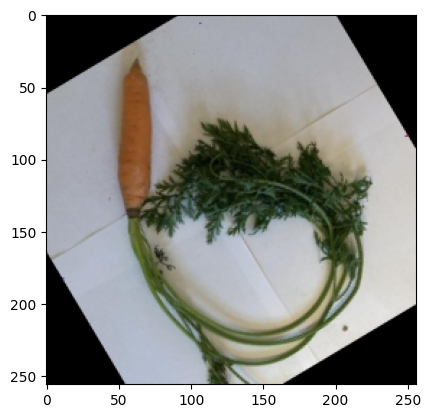

In [123]:
centerX = vegi_new_box.shape[1] // 2
print("Center X: ", centerX)
centerY = vegi_new_box.shape[0] // 2
print("Center Y: ", centerY)
M = cv2.getRotationMatrix2D((centerX, centerY), rect[2], 1.0)
rotated_2 = cv2.warpAffine(vegi_new_box, M, (vegi_new_box.shape[1], vegi_new_box.shape[0]))

show_image_plt(rotated_2)

In [144]:
#p1_x= 115.8125 p1_y= 0
#Rounded down: p1_x_new= 115
#New p2_x= 255 p2_y= 83.26797385620915
#Rounded down: p2_y_new= 83
#New p3_x= 152 p3_y= 255
#p0x = 12, p0y = 172

centerX = vegi_new_box.shape[1] / 2
print("Center X: ", centerX)
centerY = vegi_new_box.shape[0] / 2
print("Center Y: ", centerY)

points = [(12, 172, 1), (115, 0, 1), (255, 83, 1), (152, 255, 1)]
# Definiere den Punkt (Pixel)
#pixel = np.array([255, 83, 1])
#pixel = (255, 83, 1)
# Definiere die Rotationsmatrix
M = cv2.getRotationMatrix2D((centerX, centerY), rect[2], 1.0)

rotated_points = []
# Wende die Rotationsmatrix auf den Punkt an
for point in points:
    rotated_pixel = np.dot(M, point)

# Konvertiere die homogene Koordinate zurück in eine normale Koordinate
    #rotated_pixel = rotated_pixel.astype(int)
    # Die Koordinaten des rotierten Punktes
    rotated_x, rotated_y = rotated_pixel[0], rotated_pixel[1]
    #print("Rotierter Punkt:", (rotated_x, rotated_y))
    rotated_points.append((rotated_x, rotated_y))
rotated_points

Center X:  128.0
Center Y:  128.0


[(50.917177055303156, 225.21233670104078),
 (51.26372985277294, 24.730716842365027),
 (214.01755957365884, 24.293782997391844),
 (213.67100677618902, 224.77540285606756)]

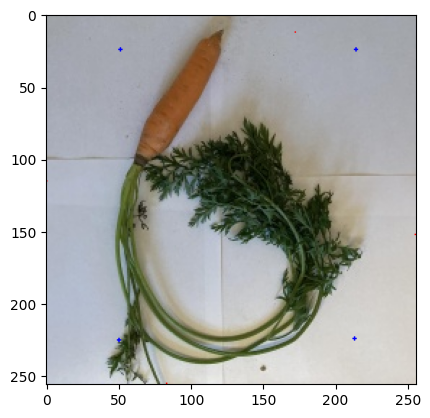

In [141]:
vegi_new_box = vegi_BGR.copy()
vegi_new_box = cv2.cvtColor(vegi_new_box, cv2.COLOR_BGR2RGB)

vegi_new_box = cv2.line(vegi_new_box, (50, 225), (50, 225), (0, 0, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, (51, 24), (51, 24), (0, 0, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, (214, 24), (214, 24), (0, 0, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, (213, 224), (213, 224), (0, 0, 255), 2)

show_image_plt(vegi_new_box)

In [59]:
from sympy import Symbol, nsolve
import mpmath
#mpmath.mp.dps = 15

x = Symbol('x')
y = Symbol('y')
f1 = 134 * x - 152 - 153 * y
f2 = 193 - 224 * x - 255 - 91 * y
erg = nsolve((f1, f2), (x, y), (-1, 1))
erg

Matrix([
[0.0935307536693496],
[-0.911548228812465]])

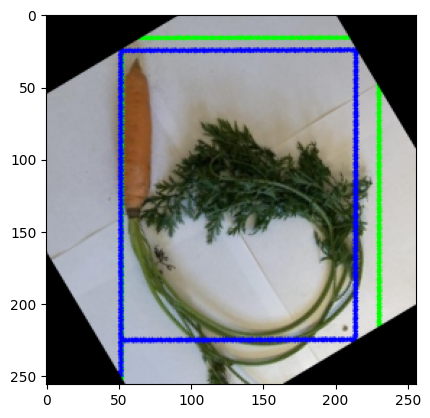

In [61]:
show_image_plt(imutils.rotate(vegi_new, rect[2]))

In [58]:
num = float(erg[0])
num

-1.0561645076546788